# Extract profiles for all proplyds and all filters

## Library imports

### General libraries

In [2]:
import numpy as np 
from pathlib import Path
import pandas as pd

### Astronomy libraries

In [43]:
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, QTable
from astropy.nddata import Cutout2D
import regions

### Graphics libraries

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set_context("talk")
sns.set_color_codes()

## Paths to the data files

In [5]:
datapath = Path.cwd().parent / "data"

## Get all the images we need in various filters

In [31]:
pcfilters = ["f631n", "f673n", "f656n", "f658n", "f547m", ]

In [35]:
class FilterImage:
    """WFPC2 PC image in a given filter
    
    Includes the following attributes:
    
    name: name of filter
    data: pixel image (hi-pass filtered)
    sdata: pixel image (lo-pass filtered)
    coords: celestial coordinates of pixels (same shape as data)
    wcs: an astropy.wcs.WCS instance
    """
    def __init__(self, name):
        self.name = name
        hdu = fits.open(
            datapath / f"align-pcmos-{self.name}_sharp_16.fits"
        )[0]
        self.wcs = WCS(hdu.header)
        self.data = hdu.data
        self.sdata = fits.open(
            datapath / f"pcmos-{self.name}_smooth_16.fits"
        )[0].data
        ny, nx = self.data.shape
        self.coords = self.wcs.pixel_to_world(
            *np.meshgrid(np.arange(nx), np.arange(ny))
        )

In [32]:
imdict = {
    name: FilterImage(name) for name in pcfilters
}

## Get all the proplyd source coordinates

Get the sources from the DS9 region file that I made by hand.

In [6]:
regfile = datapath / "pcmos-proplyds.reg"
regs = regions.Regions.read(regfile, format="ds9")

Use θ¹ Ori C as origin to define position angles.

In [7]:
c0 = SkyCoord.from_name("* tet01 Ori C")

Extract the information that we want from the region file. Construct a list of dicts that give source name and coordinates:

In [8]:
source_list = [{"Name": r.meta["label"],  "ICRS": r.center} for r in regs]

Convert to an `astropy.table.QTable` of the sources. Add columns for PA to θ¹ Ori C (in degrees) and Separation from θ¹ Ori C (in arcsec):

In [18]:
source_table = QTable(source_list)
source_table["PA"] = source_table["ICRS"].position_angle(c0).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table.add_index("Name")
source_table

Name,ICRS,PA,Sep
,"deg,deg",deg,arcsec
str11,SkyCoord,float64,float64
177-341W,"83.82363499999998,-5.394699444444445",314.98007715439655,25.432600010148143
173-341,"83.82216416666665,-5.394801388888889",325.26623943671575,22.321924813790307
170-337,"83.82073749999998,-5.393605833333334",331.55791584978465,15.967686371231176
171-340,"83.82105708333333,-5.394350833333334",332.3781956253825,18.873422933876565
180-331,"83.82514916666666,-5.391885555555556",288.5266971454808,24.69660035312236
176-325,"83.82313874999998,-5.390233888888889",276.6893443122159,16.322331463594164
168-326,"83.82016916666666,-5.390601388888889",300.0748250386534,6.4342047406945815
161-328,"83.81696666666664,-5.391016944444445",51.38552690888274,7.563771376918397


By turning the `Name` column into an index, we can extract a given source by name. For example:

In [19]:
source_table.loc["182-413"]

Name,ICRS,PA,Sep
,"deg,deg",deg,arcsec
str11,SkyCoord,float64,float64
182-413,"83.82584708333331,-5.403739722222222",332.8419926483634,56.78242731489862


The advantage of using a `QTable` is that the units remain attached to the values:

In [22]:
source_table.loc["177-341W"]["PA"], source_table.loc["180-331"]["Sep"]

(<Angle 314.98007715 deg>, <Angle 24.69660035 arcsec>)

## Cutout image of a proplyd in a particular filter

We use `astropy.nddata.Cutout2D` to make cutouts of the sharp image, the smooth image, and the coordinate array. 

In [85]:
class ProplydCutout:
    
    def __init__(self, pdata, image: FilterImage, size=2 * u.arcsec):
        self.center = pdata["ICRS"]
        self.pa_star = pdata["PA"]
        self.sep = pdata["Sep"]
        self.pname = pdata["Name"]
        self.fname = image.name
        self.size = size
        self.cutout = Cutout2D(
            image.data, position=self.center, size=size, wcs=image.wcs, copy=True,
        )
        self.image = self.cutout.data
        self.wcs = self.cutout.wcs
        # Use the slices from this cutout to also get cutout of the smoothed data array
        self.smooth_image = image.sdata[self.cutout.slices_original]
        # ... and the same for the coordinates
        self.image_coords = image.coords[self.cutout.slices_original]
        # Radius and PA of each pixel with respect to the center
        self.r = self.center.separation(self.image_coords)
        self.pa = self.center.position_angle(self.image_coords)
        # Default mask has max radius of half of cutout size
        self.set_mask(r_out=self.size / 2)
        self.owcs = self.get_ortho_wcs()
        
    def __repr__(self):
        return f"ProplydCutout({self.pname}, {self.fname})"
       
    def get_ortho_wcs(self):
        """Auxilary WCS that is orthogonal to RA, Dec
        
        Pixel size is 1 arcsec. 
        Origin is set at corner pixel, 
        which is (1, 1) in FITS, but is (0, 0) in python
        """
        wcs = WCS(naxis=2)
        wcs.wcs.cdelt = [-1/3600, 1/3600]
        wcs.wcs.crval = [self.center.ra.deg, self.center.dec.deg]
        wcs.wcs.crpix = [1, 1]
        wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        return wcs
         
    def set_mask(
        self,
        r_out = 1.0 * u.arcsec,
        r_in = 0.1 * u.arcsec,
        mu_min = -0.2,
    ):
        cth = np.cos((self.pa - self.pa_star))
        self.mask = (self.r <= r_out) & ((cth >= mu_min) | (self.r <= r_in))

Test that the cutout works:

In [73]:
p = ProplydCutout(source_table.loc["177-341W"], imdict["f547m"])

We can plot it with imshow, but that is rotated with respect to equatorial axes.

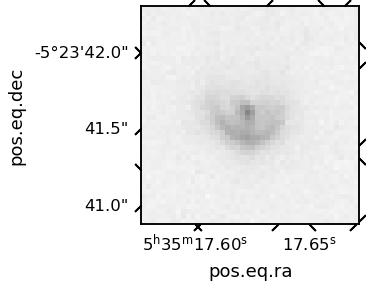

In [81]:
fig, ax = plt.subplots(subplot_kw=dict(projection=p.wcs))
ax.imshow(p.image, vmin=0, vmax=15, cmap="gray_r")
...;

We can use the orthogonal wcs and pcolormesh to rotate the image so that axes are aligned with RA and Dec.

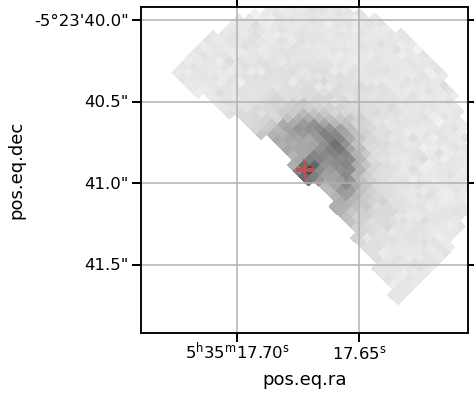

In [80]:
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw=dict(projection=p.owcs),
)
T = ax.get_transform("world")
ax.pcolormesh(
    p.image_coords.ra.deg,
    p.image_coords.dec.deg,
    np.where(p.mask, p.image, np.nan), 
    vmin=0, 
    vmax=10, 
    cmap="gray_r",
    shading="nearest",
    transform=T,
)
ax.scatter(
    p.center.ra.deg, 
    p.center.dec.deg, 
    transform=T, 
    color='r', 
    marker="+",
    s=300,
)
ax.set_aspect("equal")
ax.set(
    xlim=[-1, 1],
    ylim=[-1, 1],
)
...;

## Make cutout for all proplyds and all filters

Add them in to the table of sources

In [86]:
for fname in pcfilters:
    source_table[fname] = [ProplydCutout(row, imdict[fname]) for row in source_table]

In [95]:
source_table[pcfilters]

f631n,f673n,f656n,f658n,f547m
object,object,object,object,object
"ProplydCutout(177-341W, f631n)","ProplydCutout(177-341W, f673n)","ProplydCutout(177-341W, f656n)","ProplydCutout(177-341W, f658n)","ProplydCutout(177-341W, f547m)"
"ProplydCutout(173-341, f631n)","ProplydCutout(173-341, f673n)","ProplydCutout(173-341, f656n)","ProplydCutout(173-341, f658n)","ProplydCutout(173-341, f547m)"
"ProplydCutout(170-337, f631n)","ProplydCutout(170-337, f673n)","ProplydCutout(170-337, f656n)","ProplydCutout(170-337, f658n)","ProplydCutout(170-337, f547m)"
"ProplydCutout(171-340, f631n)","ProplydCutout(171-340, f673n)","ProplydCutout(171-340, f656n)","ProplydCutout(171-340, f658n)","ProplydCutout(171-340, f547m)"
"ProplydCutout(180-331, f631n)","ProplydCutout(180-331, f673n)","ProplydCutout(180-331, f656n)","ProplydCutout(180-331, f658n)","ProplydCutout(180-331, f547m)"
"ProplydCutout(176-325, f631n)","ProplydCutout(176-325, f673n)","ProplydCutout(176-325, f656n)","ProplydCutout(176-325, f658n)","ProplydCutout(176-325, f547m)"
"ProplydCutout(168-326, f631n)","ProplydCutout(168-326, f673n)","ProplydCutout(168-326, f656n)","ProplydCutout(168-326, f658n)","ProplydCutout(168-326, f547m)"
"ProplydCutout(161-328, f631n)","ProplydCutout(161-328, f673n)","ProplydCutout(161-328, f656n)","ProplydCutout(161-328, f658n)","ProplydCutout(161-328, f547m)"
"ProplydCutout(158-327, f631n)","ProplydCutout(158-327, f673n)","ProplydCutout(158-327, f656n)","ProplydCutout(158-327, f658n)","ProplydCutout(158-327, f547m)"


## Do the images

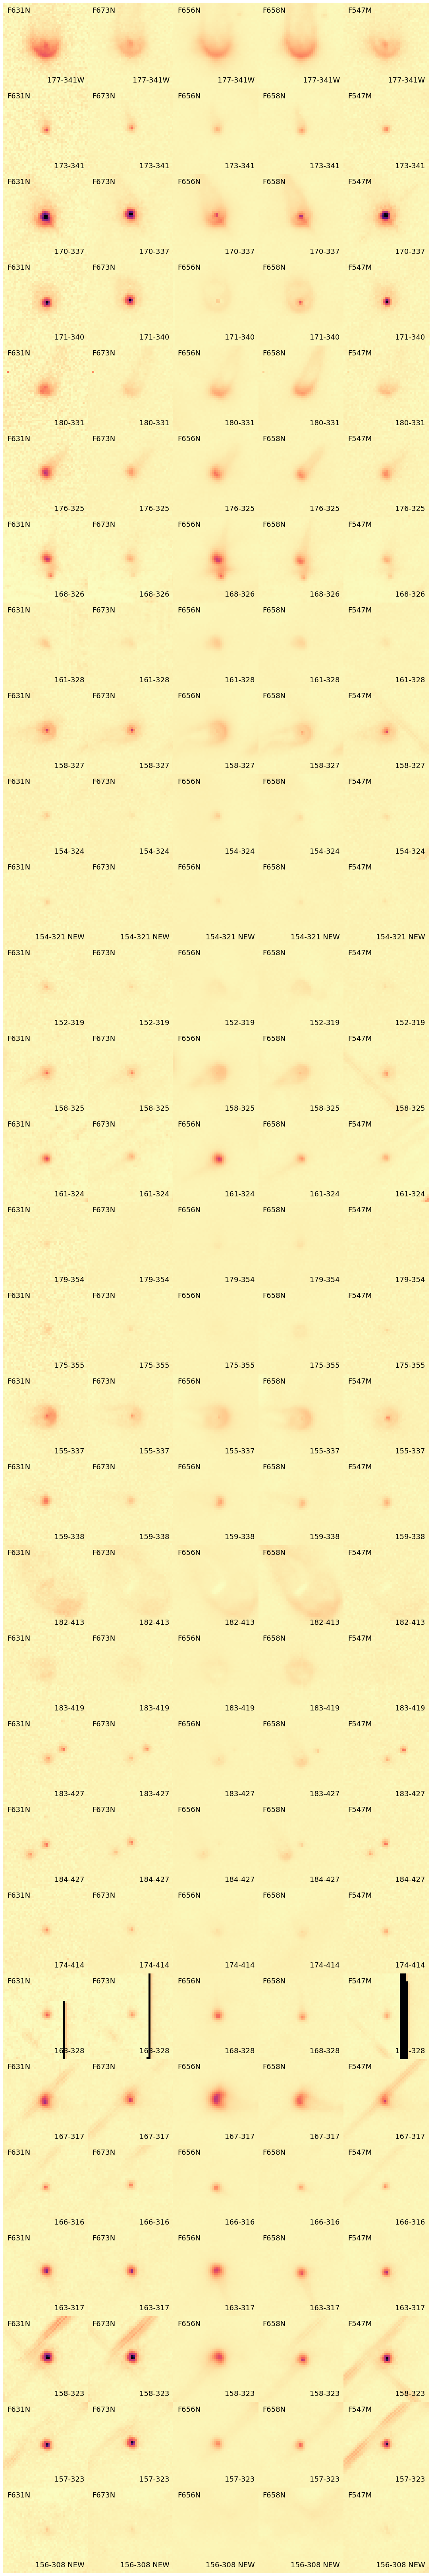

In [110]:
np = len(source_table)
ns = len(pcfilters)
fig, axes = plt.subplots(np, ns, figsize=(3 * ns, 3 * np))
for j, row in enumerate(source_table):
    for i, fname in enumerate(pcfilters):
        ax = axes[j, i]
        ax.imshow(row[fname].image**0.5, vmin=0.8, vmax=10, cmap="magma_r", origin='lower')
        ax.text(0.05, 0.95, fname.upper(), transform=ax.transAxes, va="top", ha="left")
        ax.text(0.95, 0.05, row["Name"], transform=ax.transAxes, va="bottom", ha="right")
        ax.set(xticks=[], yticks=[])
sns.despine(left=True, bottom=True)
fig.tight_layout(pad=0, h_pad=0, w_pad=0)

## Do the profiles

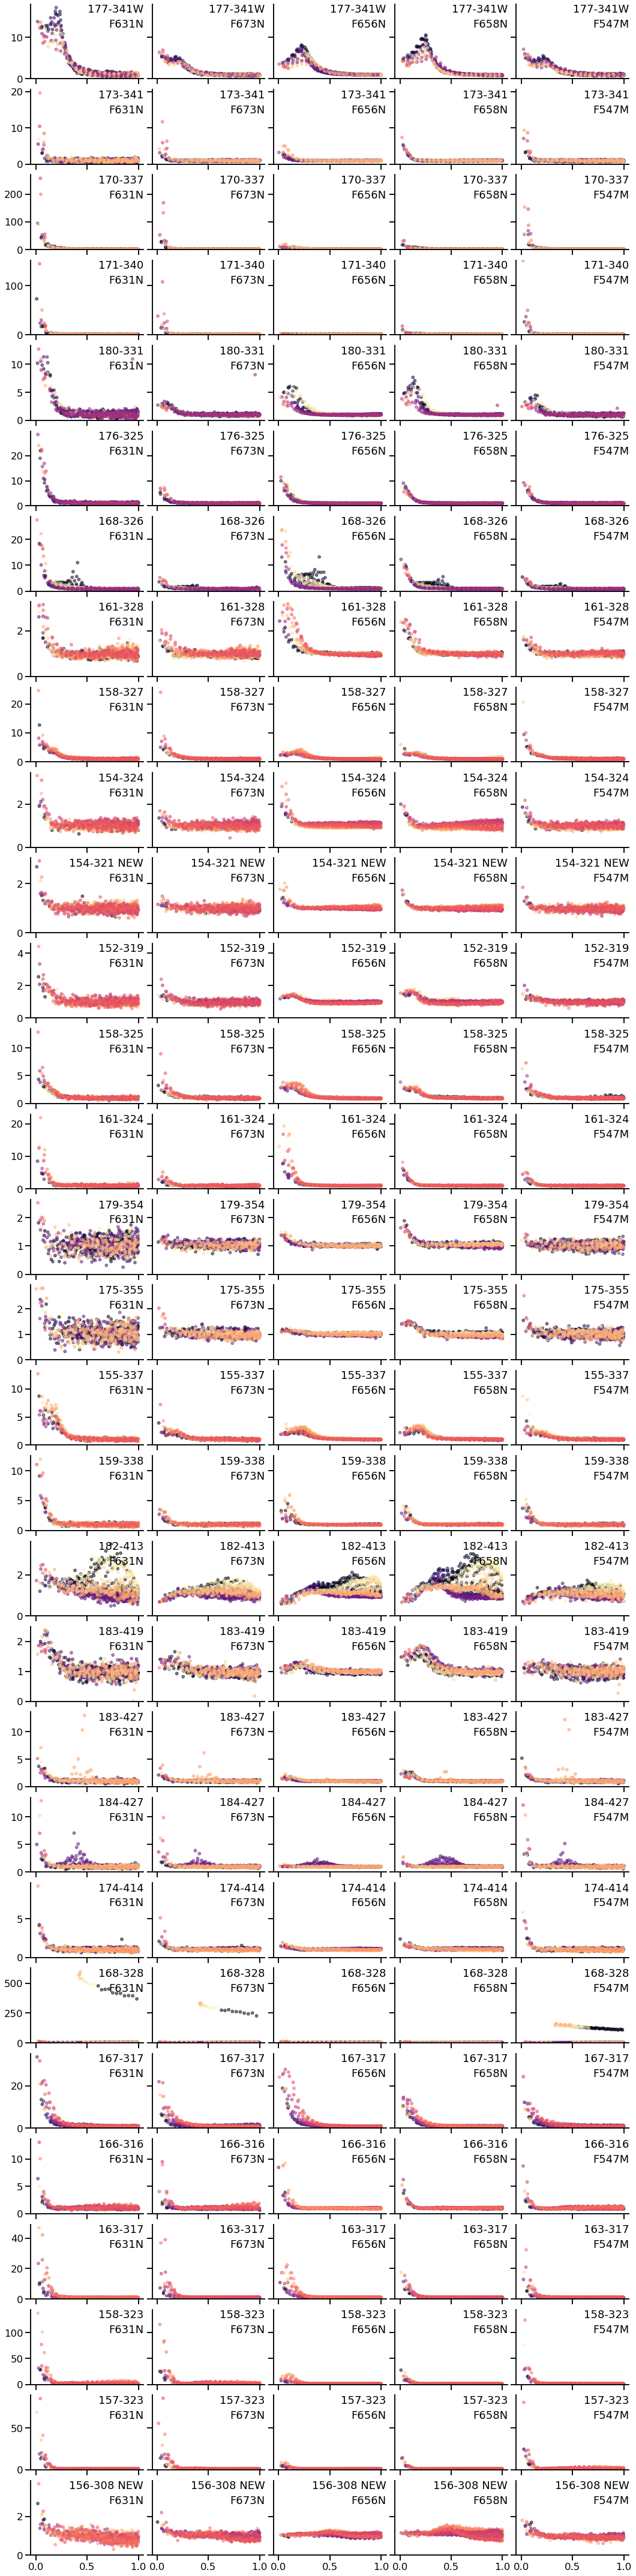

In [115]:
np = len(source_table)
ns = len(pcfilters)
fig, axes = plt.subplots(np, ns, figsize=(3 * ns, 2.0 * np), sharex=True, sharey='row')
for j, row in enumerate(source_table):
    for i, fname in enumerate(pcfilters):
        p = row[fname]
        ax = axes[j, i]
        m = p.mask
        ax.scatter(
            p.r.arcsec[m], p.image[m],
            c=(p.pa - p.pa_star)[m],
            alpha=0.5,
            cmap="magma_r",
            s=20,
        )
        ax.text(1.0, 0.8, fname.upper(), transform=ax.transAxes, va="top", ha="right")
        ax.text(1.0, 1.0, row["Name"], transform=ax.transAxes, va="top", ha="right")
        ax.set(ylim=[0.0, None])
sns.despine()
fig.tight_layout(h_pad=0.3, w_pad=0.3)

I have made sure that all the profiles in the same row share a common y scale, so that we can easily compare the different profiles. 

We can see that in many cases the 631 profile is significantly higher than the sum of the 547 and the 656.  This is good evidence that we are seeing [O I] from the neutral disk wind. 

Not all sources show this however. For instance, 167-317 is pretty dominated by Ha.

Next step is some sort of spatial averaging of the profiles. 